# OPTIMIZE MODEL

In [1]:
from sklearn.metrics import classification_report,precision_recall_curve,confusion_matrix,roc_curve,auc,accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from sklearn.base import TransformerMixin
from langdetect import detect_langs
from translate import translator
import matplotlib.pyplot as plt
import pandas as pd
% matplotlib inline
import pickle
import re

/Users/marwinko/anaconda/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## TRANSFORMERS

In [2]:
class AsciiTransformer(TransformerMixin):
    def transform(self,X,**transform_params):     
        return pd.Series(X.apply(lambda x: x.decode('ISO-8859-2').encode('ASCII','ignore')))
    def fit(self,X,y=None,**fit_params):
        return self
class ZikaCounterTransformer(TransformerMixin):
    def transform(self,X,**transform_params):
#         for text in X:
#             re.match
        return 'zika word count'
    def fit(self,X,y=None,**fit_params):
        return self
class LowerCaseTransformer(TransformerMixin):
    def transform(self,X,**transform_params):
        return 'lower case tranform'
    def fit(self,X,y=None,**fit_params):
        return self
class BiGramTransformer(TransformerMixin):
    def transform(self,X,**transform_params):
        return 'bi-grams'
    def fit(self,X,y=None,**fit_params):
        return self
class PartOfSpeechTagTransformer(TransformerMixin):
    def transform(self,X,**transform_params):
        return 'pos tags'
    def fit(self,X,y=None,**fit_params):
        return self
class StopWordsTransformer(TransformerMixin):
    def transform(self,X,**transform_params):
        return 'stop words removed'
    def fit(self,X,y=None,**fit_params):
        return self
class SentimentTransformer(TransformerMixin):
    def transform(self,X,**transform_params):
        # SIA = SentimentIntensityAnalyzer()
        # senti_score = SIA.polarity_scores('to com zika')
        return 'text sentiment'
    def fit(self,X,y=None,**fit_params):
        return self

## LOAD DATA

In [3]:
df = pd.read_csv('data/161207_ZikaLabels.csv')
df.dropna(axis=0,inplace=True) #drop NaNs or else NaNs would confuse the algorithms
X = df.diagnosisRAW
y = df.zika
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## ALGORITHMS

In [4]:
models = {}
models['Logistic_Regression'] = LogisticRegression()
models['Gauss_Naive_Bayes'] = GaussianNB()
models['Random_Forest'] = RandomForestClassifier()
models['Gradient_Boost'] = GradientBoostingClassifier()

## RUN MODELS

note to self: optimize the following parameters tomorrow...
1. SVD n_components
2. thresholds
3. n_trees for tree-based algorithms

############################################################
MODEL:Logistic_Regression 	 SCORE:0.929133858268
             precision    recall  f1-score   support

      False       0.93      1.00      0.96      1298
       True       0.00      0.00      0.00        99

avg / total       0.86      0.93      0.90      1397

[[1298    0]
 [  99    0]]


/Users/marwinko/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


############################################################
MODEL:Gradient_Boost 	 SCORE:0.926986399427
             precision    recall  f1-score   support

      False       0.93      1.00      0.96      1298
       True       0.20      0.01      0.02        99

avg / total       0.88      0.93      0.90      1397

[[1294    4]
 [  98    1]]
############################################################
MODEL:Gauss_Naive_Bayes 	 SCORE:0.32712956335
             precision    recall  f1-score   support

      False       0.92      0.30      0.45      1298
       True       0.07      0.67      0.12        99

avg / total       0.86      0.33      0.43      1397

[[391 907]
 [ 33  66]]
############################################################
MODEL:Random_Forest 	 SCORE:0.9255547602
             precision    recall  f1-score   support

      False       0.93      1.00      0.96      1298
       True       0.14      0.01      0.02        99

avg / total       0.87      0.93      0.89   

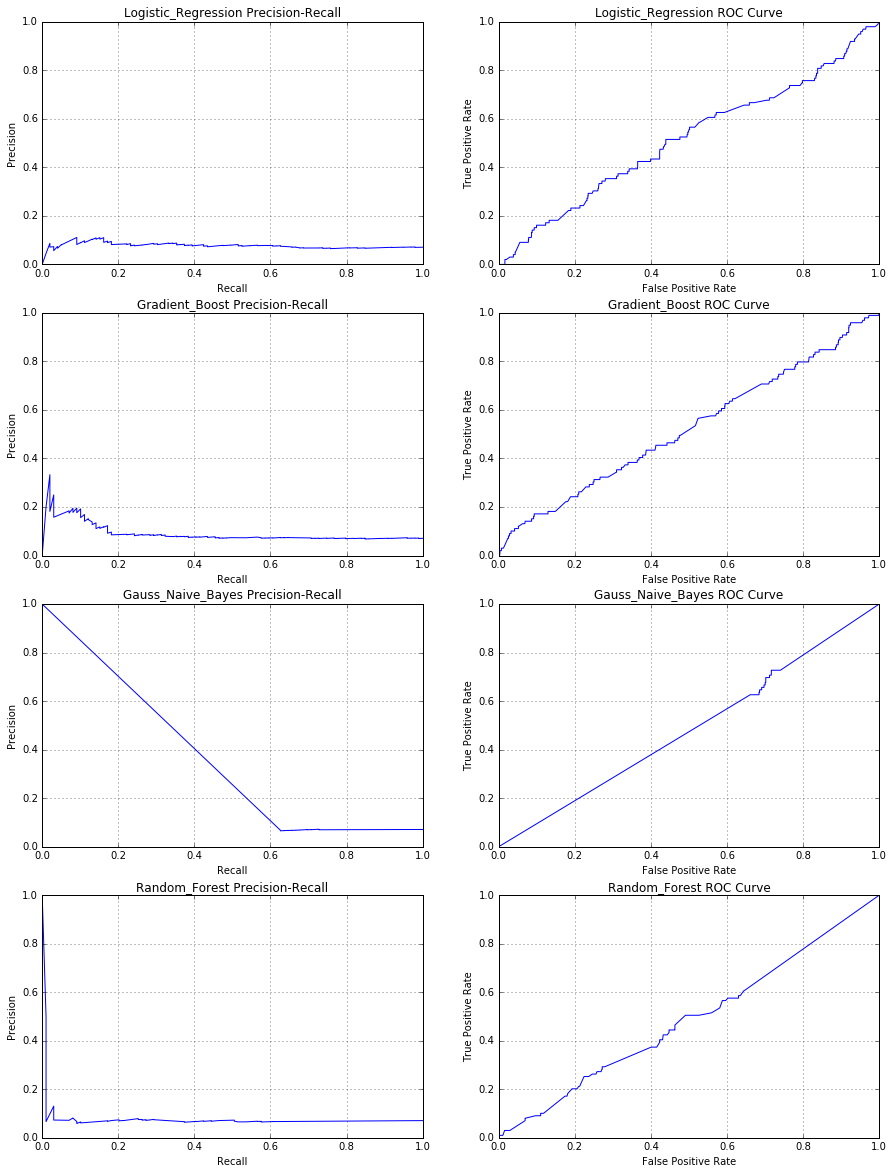

In [5]:
fig,axs = plt.subplots(nrows=len(models),ncols=2)
fig.set_figwidth(15)
fig.set_figheight(20)
i=0                       
for name,model in models.items():
    pipe = make_pipeline(AsciiTransformer(),
                        TfidfVectorizer(),
                        TruncatedSVD(500),
                        model)
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)
    y_pred_probs = pipe.predict_proba(X_test)
    score = accuracy_score(y_test,y_pred)

    precision,recall,threshold_PR = precision_recall_curve(y_test,y_pred_probs[:,1],pos_label=1)
    fpr,tpr,threshold_ROC = roc_curve(y_test,y_pred_probs[:,1],pos_label=1)
    AUC = auc(fpr,tpr)
    
    print '#'*60
    print 'MODEL:{} \t SCORE:{}'.format(name, score)
    print classification_report(y_test,y_pred)
    print confusion_matrix(y_test,y_pred)
    i+=1
    ax = axs[-1+i,0]
    ax.plot(recall,precision)
    ax.set_title(name + ' Precision-Recall')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.grid(True)
    ax = axs[-1+i,1]
    ax.plot(fpr,tpr)
    ax.set_title(name + ' ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.grid(True)

## SAVE PROTOTYPE

Save Naive Bayes model as proof of concept. Major revisions will need to be done! Must convert all languages to one specific language...

In [6]:
model = GaussianNB()
pipe = make_pipeline(AsciiTransformer(),
                    TfidfVectorizer(),
                    TruncatedSVD(500),
                    model)
pipe.fit(X_train,y_train)
with open('Naive_Bayes_MODEL1.plk','wb') as f:
    pickle.dump(pipe,f)

## TEST RUN

In [7]:
text = 'enter text here'
print 'TEXT_INPUT: \"{}\"'.format(text)
print 'PREDICTION: {}'.format(pipe.predict(pd.Series(text))[0])
print 'FALSE_PROB: {} \t TRUE_PROB: {}'.format(pipe.predict_proba(pd.Series(text))[0][0],
                                               pipe.predict_proba(pd.Series(text))[0][1])

TEXT_INPUT: "enter text here"
PREDICTION: True
FALSE_PROB: 8.68420772331e-38 	 TRUE_PROB: 1.0
